# Battle of Neighborhoods

#### Import library

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import folium
import json
from pandas.io.json import json_normalize
import requests
from requests import get
from time import sleep
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Scrape housing data from website: https://propzy.vn

In [ ]:
page_num = range(1,600)
listings = []

for page in page_num:
    headers = {'User-agent': 'phuong'}
    url = 'https://propzy.vn/mua/ban-nha-rieng-tphcm/p{}'.format(page)
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'lxml')
    apartment_containers = soup.find_all('div', class_="block-info")
    if len(apartment_containers) == 0:
        break
    for apt in apartment_containers:
        try:
            size = (apt.find_all('span', class_="span-acreage")[0].text.replace(',','.'))[0:-2]
        except:
            size = np.nan
        try:
            district = (apt.find_all('div', class_="bl-inline pull-right bl-district")[0].text)[2:]
        except:
            district = np.nan

        try:
            price = apt.find_all('span', class_="span-price")[0].text.split()[0].replace(',','.')
        except:
            price = np.nan
            
        try:
            room= apt.find_all('span', class_='elements bedroom')[0].text
        except:
            room = np.nan

        listings.append([district, size, room, price])
 
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))
df=pd.DataFrame(data=listings)

In [6]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [7]:
df.columns=['District', 'Acreage', 'Rooms','Price']

In [8]:
df['Acreage'] = pd.to_numeric(df['Acreage'],errors='coerce')
df['Rooms'] = pd.to_numeric(df['Rooms'],errors='coerce')
df['Price'] = pd.to_numeric(df['Price'],errors='coerce')

In [9]:
df.dropna(subset=['District', 'Acreage', 'Price'], inplace=True)

In [10]:
# Because Districts name are Vietnamese,
# so I create a function to convert it into no-punctuation-mark form.
def no_accent_vietnamese_col(df, col):
    s = df[col]
    s = s.replace(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', regex=True)
    s = s.replace(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', regex=True)
    s = s.replace(r'[èéẹẻẽêềếệểễ]', 'e', regex=True)
    s = s.replace(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', regex=True)
    s = s.replace(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', regex=True)
    s = s.replace(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', regex=True)
    s = s.replace(r'[ìíịỉĩ]', 'i', regex=True)
    s = s.replace(r'[ÌÍỊỈĨ]', 'I', regex=True)
    s = s.replace(r'[ùúụủũưừứựửữ]', 'u', regex=True)
    s = s.replace(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', regex=True)
    s = s.replace(r'[ỳýỵỷỹ]', 'y', regex=True)
    s = s.replace(r'[ỲÝỴỶỸ]', 'Y', regex=True)
    s = s.replace(r'[Đ]', 'D', regex=True)
    s = s.replace(r'[đ]', 'd', regex=True)
    return s
df['District']= no_accent_vietnamese_col(df,'District')

In [11]:
#Calculate price per m2
df['Price_m2']=df['Price']/df['Acreage']

In [12]:
df.head()

,District,Acreage,Rooms,Price,Price_m2
0,8,45.2,4,4.7,0.103982
1,4,69.2,7,21.5,0.310694
2,Phu Nhuan,55.0,2,6.8,0.123636
3,7,59.0,1,4.8,0.081356
4,Binh Chanh,243.0,5,13.0,0.053498


In [13]:
df.Rooms.value_counts()

2     2422
4     1476
3     1444
1      731
5      437
6      221
0      126
7       77
8       74
9       36
10      35
12      18
11      13
16      10
15      10
13       7
14       7
22       3
28       3
23       3
20       3
31       2
17       2
25       2
33       2
18       2
19       2
73       1
84       1
32       1
24       1
30       1
50       1
54       1
70       1
37       1
Name: Rooms, dtype: int64

In [14]:
# Delete some datas that are outliers
df=df[df.Rooms<=7]

In [15]:
df.head()

,District,Acreage,Rooms,Price,Price_m2
0,8,45.2,4,4.7,0.103982
1,4,69.2,7,21.5,0.310694
2,Phu Nhuan,55.0,2,6.8,0.123636
3,7,59.0,1,4.8,0.081356
4,Binh Chanh,243.0,5,13.0,0.053498


### Visualization

In [16]:
df.describe()

,Acreage,Rooms,Price,Price_m2
count,6934.000000,6934.000000,6934.000000,6934.000000
mean,65.852495,2.864292,8.304512,0.161490
std,56.922350,1.358622,97.894482,2.425873
min,1.000000,0.000000,1.050000,0.004221
25%,37.600000,2.000000,3.500000,0.069487
50%,54.000000,3.000000,4.900000,0.095493
75%,76.800000,4.000000,7.300000,0.134767
max,974.100000,7.000000,6850.000000,152.561247


C:\Users\Ty\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


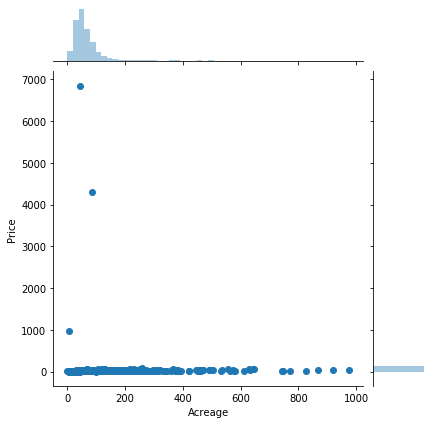

In [17]:
sns.jointplot(x='Acreage', y='Price', data=df)

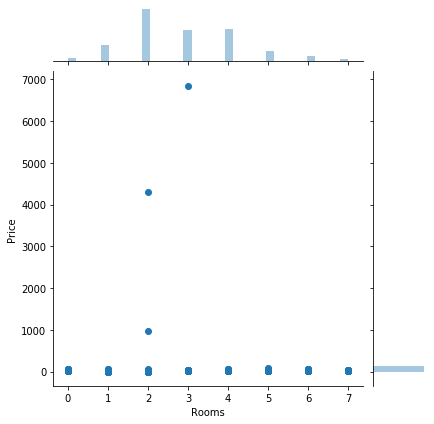

In [18]:
sns.jointplot(x='Rooms', y='Price', data=df)

In [19]:
# As you can see, there are some outlier data that will, so I delete it 
df=df[df['Price']<500]

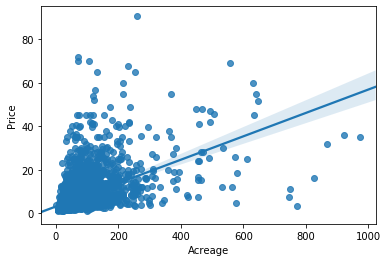

In [20]:
sns.regplot(x='Acreage', y='Price', data=df)

Now, it looks better.

#### Let's plot the box plot for the Housing price in each district.

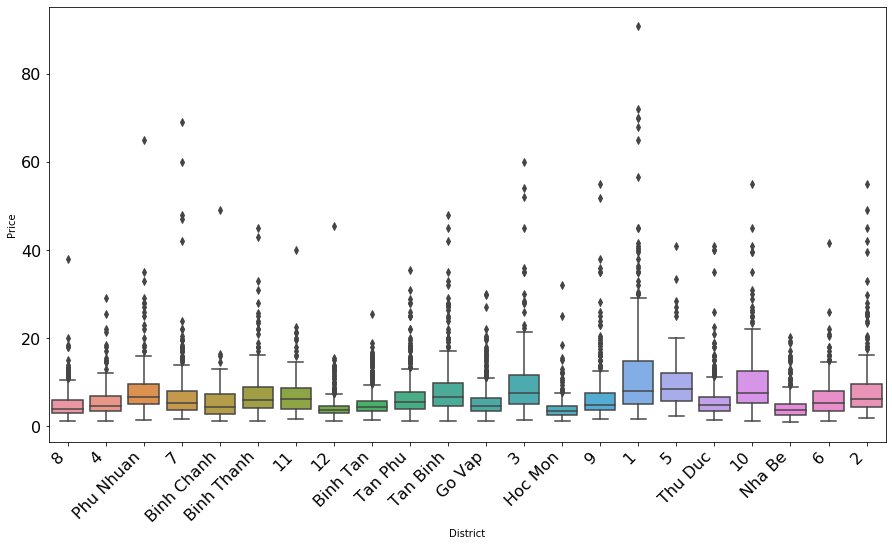

In [21]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x='District', y='Price', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(labelsize=16)

In [22]:
# The Average of Acreage, Rooms, Price in each district
avg_district= df.groupby('District').mean()
avg_district.head()

,Acreage,Rooms,Price,Price_m2
District,,,,
1,53.519725,2.481651,13.440087,0.266327
10,48.116402,2.978836,10.346455,0.217372
11,46.621302,2.603550,7.215030,0.169823
12,69.391078,2.710037,4.262117,0.066063
2,95.622222,3.022222,9.835926,0.100087


In [23]:
avg= avg_district[['Price_m2']].sort_values(by='Price_m2', ascending = True) *1000
avg.columns=['Price_m2(million vnd)']
avg.head()

,Price_m2(million vnd)
District,
Hoc Mon,45.572845
Binh Chanh,53.744036
Nha Be,61.933048
12,66.062760
9,76.344941


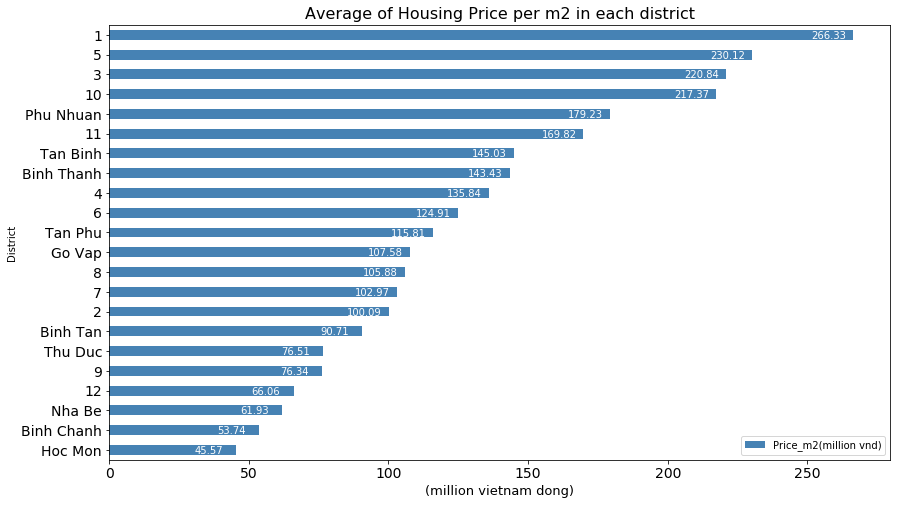

In [24]:
avg.plot(kind='barh',
        figsize=(14,8), 
        color ='steelblue',
        edgecolor=None,
        fontsize=14)
plt.title('Average of Housing Price per m2 in each district',fontsize=16)
plt.xlabel('(million vietnam dong)',fontsize=13)
# Add this loop to add the annotation
for i in range(avg.shape[0]):
    value = round(avg['Price_m2(million vnd)'][i],2)
 # place text at the end of bar (subtracting 15 from x, and 0.12 from y to make it fit within the bar)
    plt.annotate(value, xy=(value-15,i-0.19), color='white')
plt.show()

In [25]:
df.shape

(6931, 5)

#### Create a housing data dataframe consists of latitude and longitude coordinates

In [26]:
# load coordinates of districts of Ho Chi Minh City

dff=pd.read_csv(r'C:\Users\Ty\Desktop\hcm_districts_coor.csv')

lat=[]
long=[]
for i in range(0,len(dff)):
    lat.append(float(dff.coordinates[i].split(',')[0]))
    long.append(float(dff.coordinates[i].split(',')[1]))
    
dff['lat']=lat
dff['long']=long
dff.drop('coordinates', axis=1, inplace=True)

dff.head()

,District,lat,long
0,1,10.771423,106.698471
1,2,10.789293,106.751624
2,3,10.784475,106.684385
3,4,10.761667,106.702500
4,5,10.755587,106.668363


In [27]:
house=df.join(dff.set_index('District'),on='District')

In [28]:
house.head()

,District,Acreage,Rooms,Price,Price_m2,lat,long
0,8,45.2,4,4.7,0.103982,10.723333,106.627778
1,4,69.2,7,21.5,0.310694,10.761667,106.702500
2,Phu Nhuan,55.0,2,6.8,0.123636,10.801667,106.677500
3,7,59.0,1,4.8,0.081356,10.738611,106.726389
4,Binh Chanh,243.0,5,13.0,0.053498,10.750278,106.512500


In [29]:
avg=house.groupby('District').mean().reset_index()
avg.head()

,District,Acreage,Rooms,Price,Price_m2,lat,long
0,1,53.519725,2.481651,13.440087,0.266327,10.771423,106.698471
1,10,48.116402,2.978836,10.346455,0.217372,10.773611,106.667222
2,11,46.621302,2.603550,7.215030,0.169823,10.766944,106.645556
3,12,69.391078,2.710037,4.262117,0.066063,10.861944,106.658889
4,2,95.622222,3.022222,9.835926,0.100087,10.789293,106.751624


#### Create a choropleth map displays The average of price/m2 for each district in HCMC

In [30]:
with open(r'C:\Users\Ty\Desktop\district-boundary-hcm-city 12 (4).geojson') as json_data:
    hcm_geo = json.load(json_data)

In [31]:
hcm_map = folium.Map(location=[10.761944,106.594722], zoom_start=15)

# add the data
hcm_map.choropleth(
    geo_data=hcm_geo,
    data=avg,
    columns=['District', 'Price_m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in HoChiMinhCity'
) 

# display map
hcm_map

C:\Users\Ty\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [33]:
CLIENT_ID = 'CDVLOJVW3XUKQIQRR5K2PISCOL2T5I5UT3BGRYU1VQWFNYRG' # your Foursquare ID
CLIENT_SECRET = 'KIFXLXP0TKU5G35ASWKN2AYNK21YRE00HNJS3FWXXGJD4LJC' # your Foursquare Secret
VERSION = '20200218' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CDVLOJVW3XUKQIQRR5K2PISCOL2T5I5UT3BGRYU1VQWFNYRG
CLIENT_SECRET:KIFXLXP0TKU5G35ASWKN2AYNK21YRE00HNJS3FWXXGJD4LJC


In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
# run the above function on each neighborhood and create a new dataframe called *toronto_venues*
hcm_venues = getNearbyVenues(names=dff['District'],
                                   latitudes=dff['lat'],
                                   longitudes=dff['long']
                                  )

1
2
3
4
5
6
7
8
9
10
11
12
Tan Binh
Binh Tan
Phu Nhuan
Thu Duc
Binh Thanh
Tan Phu
Go Vap
Cu Chi
Hoc Mon
Nha Be
Can Gio
Binh Chanh


In [36]:
print('There are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

There are 118 uniques categories.


In [37]:
hcm_venues.shape
hcm_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.771423,106.698471,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.771423,106.698471,Maison Marou Saigon,10.769667,106.697925,Dessert Shop
2,1,10.771423,106.698471,Quán Lộc Thành,10.772472,106.698441,Vietnamese Restaurant
3,1,10.771423,106.698471,Quynh Nhu Foot Massage,10.771070,106.700277,Massage Studio
4,1,10.771423,106.698471,Bep Me In,10.773810,106.698152,Vietnamese Restaurant


In [38]:
hcm_venues.District.value_counts()

1             100
3             100
5              70
10             63
4              61
Phu Nhuan      53
Tan Binh       36
Binh Thanh     22
7              21
11             19
Go Vap         14
6              13
Binh Tan       10
Tan Phu        10
12              8
8               8
Thu Duc         7
2               5
Hoc Mon         4
Nha Be          1
Name: District, dtype: int64

In [39]:
house.District.value_counts()

Go Vap        788
Binh Tan      722
12            538
Thu Duc       526
Tan Phu       442
Nha Be        427
8             398
Tan Binh      352
9             337
Binh Thanh    266
7             252
6             226
1             218
Phu Nhuan     205
Hoc Mon       193
10            189
4             188
3             187
11            169
2             135
5              92
Binh Chanh     81
Name: District, dtype: int64

In [40]:
#### Delete rows where foursquare don't give venues data
hcm_venues.dropna(axis=0,inplace=True)
house=house[house['District']!='Binh Chanh']

In [41]:
house=house[house['District']!='9']

In [42]:
house

,District,Acreage,Rooms,Price,Price_m2,lat,long
0,8,45.2,4,4.70,0.103982,10.723333,106.627778
1,4,69.2,7,21.50,0.310694,10.761667,106.702500
2,Phu Nhuan,55.0,2,6.80,0.123636,10.801667,106.677500
3,7,59.0,1,4.80,0.081356,10.738611,106.726389
5,Binh Thanh,14.0,1,2.00,0.142857,10.806403,106.705138
...,...,...,...,...,...,...,...
7181,2,128.8,1,8.80,0.068323,10.789293,106.751624
7182,10,50.7,4,8.00,0.157791,10.773611,106.667222
7184,Thu Duc,90.0,3,13.50,0.150000,10.851576,106.744581
7185,Binh Tan,50.7,6,4.69,0.092505,10.768983,106.606505


In [43]:
# one hot encoding
house_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
house_onehot['District'] =hcm_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [house_onehot.columns[-1]] + list(house_onehot.columns[:-1])
house_onehot = house_onehot[fixed_columns]

house_onehot.head()

,District,Accessories Store,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,...,Thai Restaurant,Theater,Theme Park,Travel Agency,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Yoga Studio
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [44]:
house_grouped = house_onehot.groupby('District').mean().reset_index()
house_grouped.head()

,District,Accessories Store,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,...,Thai Restaurant,Theater,Theme Park,Travel Agency,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Yoga Studio
0,1,0.0,0.0,0.000000,0.020000,0.0,0.02,0.0,0.0,0.01,...,0.0,0.000000,0.000000,0.0,0.000000,0.01,0.180000,0.0,0.02,0.0
1,10,0.0,0.0,0.015873,0.015873,0.0,0.00,0.0,0.0,0.00,...,0.0,0.015873,0.000000,0.0,0.031746,0.00,0.206349,0.0,0.00,0.0
2,11,0.0,0.0,0.000000,0.052632,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.052632,0.0,0.052632,0.00,0.157895,0.0,0.00,0.0
3,12,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.00,0.0
4,2,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.00,0.0


In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = house_grouped['District']

for ind in np.arange(house_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(house_grouped.iloc[ind, :], num_top_venues)


In [47]:
district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Sandwich Place,Bar,Spa,Food Court,Juice Bar,Restaurant
1,10,Vietnamese Restaurant,Café,Coffee Shop,Seafood Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Ice Cream Shop,Burger Joint,Electronics Store,Korean Restaurant
2,11,Café,Vietnamese Restaurant,Seafood Restaurant,Chinese Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Asian Restaurant,Theme Park,Shopping Mall,Fast Food Restaurant
3,12,Café,Food Truck,Beer Garden,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store
4,2,Café,Coffee Shop,Snack Place,Electronics Store,Convention Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant


In [48]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 3
house_grouped_clustering = house_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(house_grouped_clustering)

In [49]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_[1:10] 

# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

house_merged = avg[['District','Price_m2','lat','long']]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
house_merged = house_merged.join(district_venues_sorted.set_index('District'), on='District')
house_merged.dropna(axis=0, inplace=True)

In [50]:
house_merged.head()

,District,Price_m2,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,0.266327,10.771423,106.698471,0.0,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Sandwich Place,Bar,Spa,Food Court,Juice Bar,Restaurant
1,10,0.217372,10.773611,106.667222,0.0,Vietnamese Restaurant,Café,Coffee Shop,Seafood Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Ice Cream Shop,Burger Joint,Electronics Store,Korean Restaurant
2,11,0.169823,10.766944,106.645556,0.0,Café,Vietnamese Restaurant,Seafood Restaurant,Chinese Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Asian Restaurant,Theme Park,Shopping Mall,Fast Food Restaurant
3,12,0.066063,10.861944,106.658889,2.0,Café,Food Truck,Beer Garden,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store
4,2,0.100087,10.789293,106.751624,0.0,Café,Coffee Shop,Snack Place,Electronics Store,Convention Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant


In [52]:
from matplotlib import cm
from matplotlib import colors
map_clusters = folium.Map(location=[10.761944, 106.594722], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(house_merged['lat'], house_merged['long'], house_merged['District'], house_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
# display map
map_clusters

In [53]:
house_merged['Cluster Labels'].value_counts()

0.0    17
2.0     2
1.0     1
Name: Cluster Labels, dtype: int64

Examine each cluster and determine the discriminating venue categories that distinguish each clusters.

#### Cluster 0

In [54]:
house_merged.loc[house_merged['Cluster Labels'] == 0,house_merged.columns[[0,1] + list(range(5,house_merged.shape[1]))]]

,District,Price_m2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,0.266327,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Sandwich Place,Bar,Spa,Food Court,Juice Bar,Restaurant
1,10,0.217372,Vietnamese Restaurant,Café,Coffee Shop,Seafood Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Ice Cream Shop,Burger Joint,Electronics Store,Korean Restaurant
2,11,0.169823,Café,Vietnamese Restaurant,Seafood Restaurant,Chinese Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Asian Restaurant,Theme Park,Shopping Mall,Fast Food Restaurant
4,2,0.100087,Café,Coffee Shop,Snack Place,Electronics Store,Convention Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant
5,3,0.220843,Café,Vietnamese Restaurant,Coffee Shop,Asian Restaurant,Seafood Restaurant,French Restaurant,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Food Truck
6,4,0.135845,Vietnamese Restaurant,Seafood Restaurant,Café,Food,BBQ Joint,Snack Place,Boat or Ferry,Coffee Shop,Flea Market,History Museum
7,5,0.230119,Vietnamese Restaurant,Chinese Restaurant,Café,Dim Sum Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Noodle House,Dessert Shop,Coffee Shop,Seafood Restaurant
8,6,0.124912,Café,Department Store,Bookstore,Flea Market,Supermarket,Fast Food Restaurant,Movie Theater,Bagel Shop,Asian Restaurant,Vietnamese Restaurant
9,7,0.102968,Vietnamese Restaurant,Hotel,Convenience Store,Flea Market,Gym / Fitness Center,Scandinavian Restaurant,Electronics Store,Supermarket,Bed & Breakfast,Residential Building (Apartment / Condo)
10,8,0.105879,Café,Accessories Store,General Travel,Coffee Shop,Shopping Mall,Market,Residential Building (Apartment / Condo),Gift Shop,Fast Food Restaurant,Cupcake Shop


#### Cluster 1: 

In [55]:
house_merged.loc[house_merged['Cluster Labels'] == 1,house_merged.columns[[0,1] + list(range(5,house_merged.shape[1]))]]

,District,Price_m2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Nha Be,0.061933,Electronics Store,Yoga Studio,French Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Fast Food Restaurant,Flea Market


#### Cluster 2:

In [56]:
house_merged.loc[house_merged['Cluster Labels'] == 2,house_merged.columns[[0,1] + list(range(5,house_merged.shape[1]))]]

,District,Price_m2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,12,0.066063,Café,Food Truck,Beer Garden,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store
16,Hoc Mon,0.045573,Café,Arts & Crafts Store,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant


In [57]:
# create map
map_clusters = folium.Map(location=[10.761944, 106.594722], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add the data
map_clusters.choropleth(
    geo_data=hcm_geo,
    data=avg,
    columns=['District', 'Price_m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in HoChiMinhCity'
) 

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(house_merged['lat'], house_merged['long'], house_merged['District'], house_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
# display map
map_clusters

C:\Users\Ty\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
